In [30]:
import pandas as pd
import pickle
from numpy.lib.stride_tricks import sliding_window_view
from sklearn import linear_model
from finch import FINCH
import numpy as np
from tslearn.metrics import dtw
from matplotlib import pyplot as plt
import seaborn as sns
import networkx as nx
import dgl
import torch as th
from torch import nn
from torch.nn import functional as F
#from torch.autograd import Variable
#from itertools import combinations
from dgl.nn import SAGEConv, GATConv, ChebConv, SGConv, PNAConv, GMMConv, TAGConv
from sklearn.metrics import balanced_accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
#from torch_geometric.utils import from_networkx
import random
import warnings
import umap
from sklearn.decomposition import PCA
# from torch_geometric.data import Data

warnings.filterwarnings('ignore')
seed = 1024
random.seed(seed)
np.random.seed(seed)
th.manual_seed(seed)
# g_cpu = th.Generator(seed)
# g_cpu.manual_seed(seed)

In [84]:
def load_data(path_to_data=None):
    file = open(path_to_data, 'rb')
    dico = pickle.load(file)
    patterns = dico['patterns']
    evolving_graphs = dico['evolving graphs']
    nbre_steps = dico['nbre_steps']
    data = dico['data']
    return patterns, evolving_graphs, nbre_steps, data

def reshape_sequence(subsequence, lag):
    mat = sliding_window_view(subsequence, lag)[::1, :]
    X, y = mat[:, 0:-1], mat[:, -1]
    return X, y

def view_pattern(patterns_, number_steps, title1, title2):
    fr = {}
    fr['Timestamps'] = ['T'+str(i+1) for i in range(number_steps)]
    print(number_steps)
    for mod in patterns_:
        fr[mod] = np.zeros(number_steps)
        for i, step in enumerate(patterns_[mod]['steps']):
            fr[mod][step-1] = len(patterns_[mod]['voters'][i])
    fr = pd.DataFrame(fr)
    k = 3
    models = []
    for mod in list(fr):
        models.append(mod+'_')
        vec = []
        vec2 = []
        for el in fr[mod]:
            if el == 0:
                vec.append(np.nan)
                vec2.append(np.nan)
            else:
                vec.append(el)
                vec2.append(k)
        k += 1
        fr[mod] = vec
        fr[mod+'_'] = vec2
    fr.set_index('Timestamps', inplace=True)
    fig = plt.figure(dpi=150, figsize=(32,4))
    axe1 = fig.add_subplot(121)
    sns.lineplot(data=fr.loc[:, [col for col in list(fr) if col not in models]], ax=axe1, marker='o', legend=False, markersize=3)
    axe1.grid(True)
    axe1.set_title(title1, fontsize=18)
    axe1.set_ylabel('Nbre exhibited sequences', fontsize=16)
    axe1.set_xticklabels(['T'+str(i+1) for i in range(number_steps)], fontsize=8, rotation=90)

    axe2 = fig.add_subplot(122)
    sns.lineplot(data=fr.loc[:,models], ax=axe2, legend=False, marker='o', lw=2, alpha=1, markersize=3)
    axe2.grid(True)
    axe2.set_title(title2, fontsize=18)
    axe2.set_ylabel('Model index', fontsize=16)
    axe2.set_xticklabels(['T' + str(i + 1) for i in range(number_steps)], fontsize=8, rotation=90)
    plt.show()
    
def view_causal_relations(patterns_, list_graphs):

    fig = plt.figure(figsize=(52, 8), dpi=90)
    cpt = 1
    for step in list_graphs:
        axe = fig.add_subplot(1, len(list_graphs), cpt)
        print(step, list_graphs[step]['nx_graph'], list_graphs[step]['dgl_graph'])
        G = list_graphs[step]['nx_graph']
        nx.draw_networkx(
            G,
            pos=nx.drawing.layout.bipartite_layout(G, [i for i in range(len(patterns_))]),
            width=3,
            ax=axe
        )
        axe.set_title(step)
        cpt += 1
    plt.show()

def view_embedding_(data_points, projection='UMAP'):
    fig = plt.figure(figsize=(8,8), dpi=120)
    ax = fig.add_subplot(111)
    mapper = None
    if projection == 'UMAP':
        mapper = umap.UMAP().fit_transform(data_points.detach().numpy())
    if projection == 'PCA':
        mapper = PCA(n_components=2).fit_transform(data_points.detach().numpy())
        
    ax.plot(mapper[:int(len(mapper)/2),0], mapper[:int(len(mapper)/2),1], '*', color='darkblue')
    ax.plot(mapper[int(len(mapper)/2):,0], mapper[int(len(mapper)/2):,1], '*', color='darkred')
    ax.set_ylabel('UMAP-1')
    ax.set_xlabel('UMAP-2')
    plt.show()

def view_training_loss(dico):
    fig = plt.figure(dpi=120, figsize=(24, 6))
    l = min([len(val) for val in dico.values()])
    dico2 = {}
    for k,v in dico.items():
        dico2[k] = v[0:l]
    data = pd.DataFrame(dico2)
    for i, name in enumerate(list(data)):
        axe = fig.add_subplot(1, 3, i+1)
        data[name].plot(ax=axe)
        axe.set_title(name, fontsize=18)
        plt.xticks(fontsize=15)
        plt.yticks(fontsize=15)
    plt.show()

class gnn_net(nn.Module):

    def __init__(self, in_feat, hidden_feat, k=1, aggregator='pool', name='TAG'):
        super(gnn_net,self).__init__()

        self.projector = nn.ModuleList()
        if name == 'TAG':
            self.projector.append(TAGConv(in_feat, hidden_feat[0], k))
            for i in range(1, len(hidden_feat)):
                self.projector.append(TAGConv(hidden_feat[i - 1], hidden_feat[i], k))
        if name == 'SAGE':
            self.projector.append(SAGEConv(in_feat, hidden_feat[0], aggregator))
            for i in range(1, len(hidden_feat)):
                self.projector.append(SAGEConv(hidden_feat[i - 1], hidden_feat[i], aggregator))

    def forward(self, g, X):
        h = X
        for i, layer in enumerate(self.projector):
            h = layer(g, h)
            h = F.dropout(F.relu(h))
        return h

class custom_activation(nn.Module):
    def __init__(self):
        super(custom_activation, self).__init__()
#         self.threshold = threshold

    def forward(self, x, threshold):
        x[x >= threshold] = 1#th.tensor(1,dtype=th.int)
        x[x < threshold] = 0#th.tensor(0, dtype=th.int)
        return x

class autoencoder2(nn.Module):
    def __init__(
            self,
            in_feats_encoder,
            hidden_feats_encoder,
            k,
            graph_lag,
            hidden_feats_node_decoder,
            hidden_feats_edge_decoder,
            dropout=0.1,
            threshold=.15
    ):
        super(autoencoder2, self).__init__()
        self.dropout = dropout
        self.activation = custom_activation()
        self.threshold = threshold

        # Encoder model
        self.encoder = nn.ModuleList()

        for i in range(graph_lag):
            net = gnn_net(in_feats_encoder, hidden_feats_encoder, k)
            if i == graph_lag - 1:
                self.encoder.append(nn.Linear(hidden_feats_encoder[-1] * (i), hidden_feats_encoder[-1], bias=False))
            self.encoder.append(net)

        # Decoder model

        ## 1- Node decoder
        self.decod_node_layers = nn.ModuleList()

        self.decod_node_layers.append(nn.Linear(hidden_feats_encoder[-1] * graph_lag, hidden_feats_node_decoder[0], bias=False))

        for i in range(1, len(hidden_feats_node_decoder)):
            self.decod_node_layers.append(nn.Linear(hidden_feats_node_decoder[i - 1], hidden_feats_node_decoder[i]))

        self.reset_parameters()

    def reset_parameters(self):
        gain = nn.init.calculate_gain('relu')
        for layer in self.decod_node_layers:
            nn.init.xavier_uniform_(layer.weight, gain=gain)

        nn.init.xavier_uniform_(self.encoder[-2].weight, gain=gain)

    def forward(self, list_g, list_features):

        # Encoding the subsequent graphs
        whole = []
        embeddings = []
        count = 0
        
        for g, X in zip(list_g[0:-1], list_features[0:-1]):
            h = self.encoder[count](g, X)
            embeddings.append(h)
            whole.append(h)
        whole.append(self.encoder[-2](th.cat(embeddings, 1)))
        h = self.encoder[-1](list_g[-1], list_features[-1])
        embeddings.append(h)
        whole.append(h)

        # Graph construction
        h_node_embeddings = th.cat(embeddings, 1)
        h_edge_embeddings = []
        for i in range(int(len(h_node_embeddings) / 2)):
            for j in range(int(len(h_node_embeddings) / 2), len(h_node_embeddings)):
                vec = th.cat([h_node_embeddings[i, :].reshape(1, -1), h_node_embeddings[j, :].reshape(1, -1)], 1)
                h_edge_embeddings.append(vec)
        h_edge_embeddings = th.cat(h_edge_embeddings, 0)

        ## 1- node reconstruction
        h_node_features = h_node_embeddings
        for i, layer in enumerate(self.decod_node_layers):
            h_node_features = layer(h_node_features)
            h_node_features = self.activation(F.dropout(h_node_features, p=self.dropout), self.threshold)
        return h_node_embeddings, whole, h_node_features

def train_net2(list_graphs, graph_lag, device,model, epochs=50, lr=0.005, weight_decay=0.005,
              loss_encod = F.l1_loss, loss_node = F.binary_cross_entropy
              ):
    optimizer = th.optim.SGD(model.parameters(), lr=lr, weight_decay=weight_decay)
    losses = {}
    losses['encoder'] = []
    losses['node_decoder'] = []
    losses['merge'] = []

    inputs, target_node_features, target_edge_features = [], [], []
    for i in range(len(list_graphs)-graph_lag):
        seq = list_graphs[i:i+graph_lag]
        gr = list_graphs[i+graph_lag]
        # print(gr.edges())
        inputs.append(seq)
        target_node_features.append(gr.ndata['features'].to(device=device, dtype=th.float))
        w = th.zeros(int(gr.num_nodes()/2)**2)
        from_ = gr.edges()[0].tolist()
        to_ = gr.edges()[1].tolist()
        posi = []
        edge_posi = [(a,b) for a, b in zip(from_, to_)]
        for a in range(int(gr.num_nodes()/2)):
            for b in range(int(gr.num_nodes()/2), gr.num_nodes()):
                posi.append((a,b))
        for a, b in zip(from_, to_):
            w[posi.index((a,b))] = gr.edata['weight'][edge_posi.index((a,b))]

        target_edge_features.append(w.to(device=device, dtype=th.float))

    model.train()
    for e in range(epochs):

        for i, list_g in enumerate(inputs):
            list_feat = []
            for gr in list_g:
                feat = gr.ndata['features'].to(device=device, dtype=th.float)
                list_feat.append(feat)
            h_node_embeddings,whole, h_node_features = model(list_g, list_feat)
            loss0 = loss_encod(whole[-2], whole[-1])
#             loss1 = loss_node(h_node_features.flatten(), target_node_features[i].flatten())
            loss1 = loss_encod(h_node_features.sum(axis=0), target_node_features[i].sum(axis=0))
            
            loss = loss0 + loss1 
            losses['encoder'].append(loss0.item())
            losses['node_decoder'].append(loss1.item())
            losses['merge'].append(loss.item())

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()


        if e % 10 == 0:
            print(
                'In epoch {}, node_encoder:{:.5f}, node_decoder: {:.5f}, whole_loss: {:.5f}'.format(
                    e, loss0, loss1, loss))
    return losses


def node_prediction(list_true_node_features, list_true_edges, list_predicted_node_features):

    def predicted_edges(feat_node):
        n = int(feat_node.shape[0]/2)
        val = []
        for i in range(n):
            vec1 = feat_node[i,:]
            for j in range(n, feat_node.shape[0]):
                vec2 = feat_node[j,:]
                test = False
                for el in vec1 + vec2:
                    if el > 1:
                        val.append(1)
                        test = True
                        break
                if test == False:
                    val.append(0)
        return val

    pred = list_predicted_node_features.to(dtype=th.int).detach().numpy()
    true = list_true_node_features.to(dtype=th.int).detach().numpy()
    true_e = list_true_edges
    pred_e = predicted_edges(pred)
    print(len(true_e), len(pred_e))
    error_node_features, error_edge_features = {}, {}
    error_node_features['Accuracy'] = np.zeros(len(list_true_node_features))
    error_node_features['Precision'] = np.zeros(len(list_true_node_features))
    error_node_features['Recall'] = np.zeros(len(list_true_node_features))
    error_node_features['F-one'] = np.zeros(len(list_true_node_features))

    error_edge_features['Accuracy'] = np.zeros(len(list_true_node_features))
    error_edge_features['Precision'] = np.zeros(len(list_true_node_features))
    error_edge_features['Recall'] = np.zeros(len(list_true_node_features))
    error_edge_features['F-one'] = np.zeros(len(list_true_node_features))

    for i in range(len(list_true_node_features)):
        error_node_features['Accuracy'][i] = balanced_accuracy_score(true[i,:], pred[i,:])
        error_node_features['Precision'][i] = precision_score(true[i,:], pred[i,:], zero_division=1)
        error_node_features['Recall'][i] = recall_score(true[i,:], pred[i,:], zero_division=1)
        error_node_features['F-one'][i] = f1_score(true[i,:], pred[i,:], zero_division=1)

        error_edge_features['Accuracy'][i] = balanced_accuracy_score(true_e, pred_e)
        error_edge_features['Precision'][i] = precision_score(true_e, pred_e, zero_division=1)
        error_edge_features['Recall'][i] = recall_score(true_e, pred_e, zero_division=1)
        error_edge_features['F-one'][i] = f1_score(true_e, pred_e, zero_division=1)

    return pd.DataFrame(error_node_features), pd.DataFrame(error_edge_features)

def node_edge_prediction(list_true_node_features, list_true_edges, list_predicted_node_features, list_predicted_edges, threshold1, threshold2):
    error_node_features, error_edge_features = {}, {}
    error_node_features['Accuracy'] = np.zeros(len(list_true_node_features))
    error_node_features['Precision'] = np.zeros(len(list_true_node_features))
    error_node_features['Recall'] = np.zeros(len(list_true_node_features))
    error_node_features['F-one'] = np.zeros(len(list_true_node_features))

    error_edge_features['Accuracy'] = np.zeros(len(list_true_node_features))
    error_edge_features['Precision'] = np.zeros(len(list_true_node_features))
    error_edge_features['Recall'] = np.zeros(len(list_true_node_features))
    error_edge_features['F-one'] = np.zeros(len(list_true_node_features))

    for i in range(len(list_true_node_features)):
        node_pred = list_predicted_node_features[i]
        for k in range(node_pred.shape[0]):
            node_pred[k,:] = np.array([n if n > threshold1 else 0 for n in node_pred[k,:] ])
        error_node_features['Accuracy'][i] = balanced_accuracy_score(list_true_node_features.flatten(), node_pred.flatten())
        error_node_features['Precision'][i] = precision_score(list_true_node_features.flatten(), node_pred.flatten())
        error_node_features['Recall'][i] = recall_score(list_true_node_features.flatten(), node_pred.flatten())
        error_node_features['F-one'][i] = f1_score(list_true_node_features.flatten(), node_pred.flatten())

        edge_pred = list_predicted_edges[i]

    return pd.DataFrame(error_node_features)

def forecasting(past_values, current_values, model):
    forecast = {}
    forecast['series'] = current_values
    h = np.concatenate([past_values.flatten(), current_values.flatten()])
    X, y = reshape_sequence(h, 3)
    yhat = model.predict(X)[-len(current_values):]
    forecast['predict'] = yhat
    forecast['MSE'] = mse(current_values, yhat)
    forecast['MAE'] = mae(current_values, yhat)
    return forecast

def main(path_to_data=None, size=42, moving_step=30, lag=3, k=3, graph_lag=5,hidden_feats_encoder=[30, 5],
         hidden_feats_node_decoder=[3, 76],hidden_feats_edge_decoder=[3, 1],device='cpu',nbre_epoch=150,
         loss_encod = F.l1_loss, loss_node=F.mse_loss,
         view_pattern_lifespan=False, view_causal_graph=False, view_training=True, view_embedding=True):

    patterns, evolving_graphs, nbre_steps, data = load_data(path_to_data)
    print(data)
    print(len(patterns))

    if view_pattern_lifespan:
        for mod in patterns:
            print(mod)

            for i, voters in enumerate(patterns[mod]['voters']):
                print(patterns[mod]['steps'][i], len(voters), end=',')
            print('\n -----------------')

        equation = r'$'
        for i in range(lag):
            if i == 0:
                equation += 'a_' + str(i)
            else:
                equation += ' + a_' + str(i) + 'x_'+str(i)
        equation += '$'
        title1 = 'Patterns lifespan with respect to\n the number of sequences exhibited\n' + 'linear model: ' + equation
        title2 = 'Patterns lifespan with respect to\n the time duration\n' + 'linear model: ' + equation
        view_pattern(patterns, nbre_steps, title1, title2)

    if view_causal_graph:
        view_causal_relations(patterns, evolving_graphs)
    hidden_feats_node_decoder.append(data.shape[1])
    
    net = autoencoder2(in_feats_encoder=data.shape[1], hidden_feats_encoder=hidden_feats_encoder,
                      k=k, graph_lag=graph_lag, hidden_feats_node_decoder=hidden_feats_node_decoder,
                      hidden_feats_edge_decoder=hidden_feats_edge_decoder,dropout=.01)
    print(net)
    
    list_graphs = []
    for i in range(len(evolving_graphs)):
        gr = evolving_graphs[str(i+1)+'-'+str(i+2)]['dgl_graph']
        list_graphs.append(gr)

    

    losses = train_net2(list_graphs[0:-2], graph_lag=graph_lag, device=device, model=net, epochs=nbre_epoch, lr=0.01,
                       weight_decay=0.0005, loss_encod=loss_encod, loss_node=loss_node)

   
    if view_training:
        view_training_loss(losses)

    list_g = []
    list_feat = []
    for gr in list_graphs[-graph_lag-2:-2]:
        feat = gr.ndata['features'].to(device=device, dtype=th.float)
        list_g.append(gr)
        list_feat.append(feat)
    h_node_embeddings,whole, h_node_features = net(list_g, list_feat)
    
    if view_embedding:
        view_embedding_(h_node_embeddings, projection='PCA')
     
    tmp = []
    for i in range(int(list_g[-1].num_nodes()/2)):
        for j in range(int(list_g[-1].num_nodes()/2), list_g[-1].num_nodes()):
            tmp.append((i, j))
    y = np.zeros(int(list_g[-1].num_nodes()/2) ** 2).tolist()
    for a, b in zip(list_g[-1].edges()[0].tolist(), list_g[-1].edges()[1].tolist()):
        y[tmp.index((a, b))] = 1
    nodes_feat, edge_feat = node_prediction(list_g[-1].ndata['features'],y, h_node_features)
    print(nodes_feat.mean(axis=0))
    print(edge_feat.mean(axis=0))

    print('-----------------------------------')
    return patterns, evolving_graphs, nbre_steps, data, net, h_node_features

#     list_g = []
#     list_feat = []
#     for gr in list_graphs[-graph_lag - 1:-1]:
#         feat = gr.ndata['features'].to(device=device, dtype=th.float)
#         list_g.append(gr)
#         list_feat.append(feat)
#     h_node_embeddings, whole, h_node_features = net(list_g, list_feat)
    
#     tmp = []
#     for i in range(int(list_g[-1].num_nodes() / 2)):
#         for j in range(int(list_g[-1].num_nodes() / 2), list_g[-1].num_nodes()):
#             tmp.append((i, j))
#     y = np.zeros(int(list_g[-1].num_nodes() / 2) ** 2).tolist()
#     for a, b in zip(list_g[-1].edges()[0].tolist(), list_g[-1].edges()[1].tolist()):
#         y[tmp.index((a, b))] = 1
#     # print(len(y))
#     nodes_feat, edge_feat = node_prediction(list_g[-1].ndata['features'], y, h_node_features)
#     print(nodes_feat.mean(axis=0))
#     print(edge_feat.mean(axis=0))

    

In [226]:
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/SP500/info_tech_sector38_29.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/info_tech_sector38_29.pkl'
# size=38  
# moving_step=29  

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/columbus/Columbus_ETFs-2023-03-30_(no Na)259_209.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/Columbus_ETFs-2023-03-30_(no Na)259_209.pkl'
# size=259  
# moving_step=209   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/FX/FXs_interpolated417_218.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/mlp/FXs_interpolated417_218.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/FXs_interpolated417_218.pkl'
# size=417  
# moving_step=218  

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/world_indices/world_indices_reduced52_26.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/world_indices_reduced52_26.pkl'
# size=52  
# moving_step=26   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/NYCT/passengers144_102.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/passengers144_102.pkl'
# size=144  
# moving_step=102   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/eog/eog125_72.pkl'
# size=125 
# moving_step=72   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/GPS/gps_data987_813.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/gps_data987_813.pkl'
# size=987  
# moving_step=813   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/rock/rock_data284_172.pkl'
# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/rock_data284_172.pkl'
# size=284  
# moving_step=172   

# path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/tpami_exploratory/eqd/eqd23_21.pkl'
path_to_data = '/home/etienne/Causal-Inference-Graph-Modeling-in-CoEvolving-Time-Sequences/pattern_identification_dossier/kdd/svr/eqd23_21.pkl'
size=23  
moving_step=21 


lag=3
k=1
graph_lag=2
hidden_feats_encoder=[30, 50, 75]
hidden_feats_node_decoder=[75, 50, 30]
nbre_epoch=150
loss_encod = F.mse_loss
loss_node=F.binary_cross_entropy_with_logits
view_pattern_lifespan=False
view_causal_graph=True
view_training=True



                                      1         2         3         4  \
1970-01-01 00:00:00.000000000 -0.531898 -0.544098  2.657323 -0.558105   
1970-01-01 00:00:00.000000001  1.725332 -0.378397 -0.376304 -0.402002   
1970-01-01 00:00:00.000000002  2.362396 -0.341203 -0.338968 -0.366963   
1970-01-01 00:00:00.000000003 -0.543937 -0.557292 -0.555884 -0.570534   
1970-01-01 00:00:00.000000004 -0.601269  2.006444  1.164900 -0.629727   
...                                 ...       ...       ...       ...   
1970-01-01 00:00:00.000000134  1.351822 -0.580052 -0.578731 -0.591975   
1970-01-01 00:00:00.000000135 -0.569938 -0.585788 -0.584489 -0.597379   
1970-01-01 00:00:00.000000136  1.641553  2.008848 -0.581349 -0.594432   
1970-01-01 00:00:00.000000137 -0.468061 -0.474137 -0.472410 -0.492196   
1970-01-01 00:00:00.000000138 -0.482256  1.589026 -0.488026 -0.506851   

                                      5         6         7         8  \
1970-01-01 00:00:00.000000000 -0.521468 -0.550444 

20-21 DiGraph with 174 nodes and 45 edges Graph(num_nodes=174, num_edges=45,
      ndata_schemes={'features': Scheme(shape=(512,), dtype=torch.float64)}
      edata_schemes={'weight': Scheme(shape=(), dtype=torch.float64)})


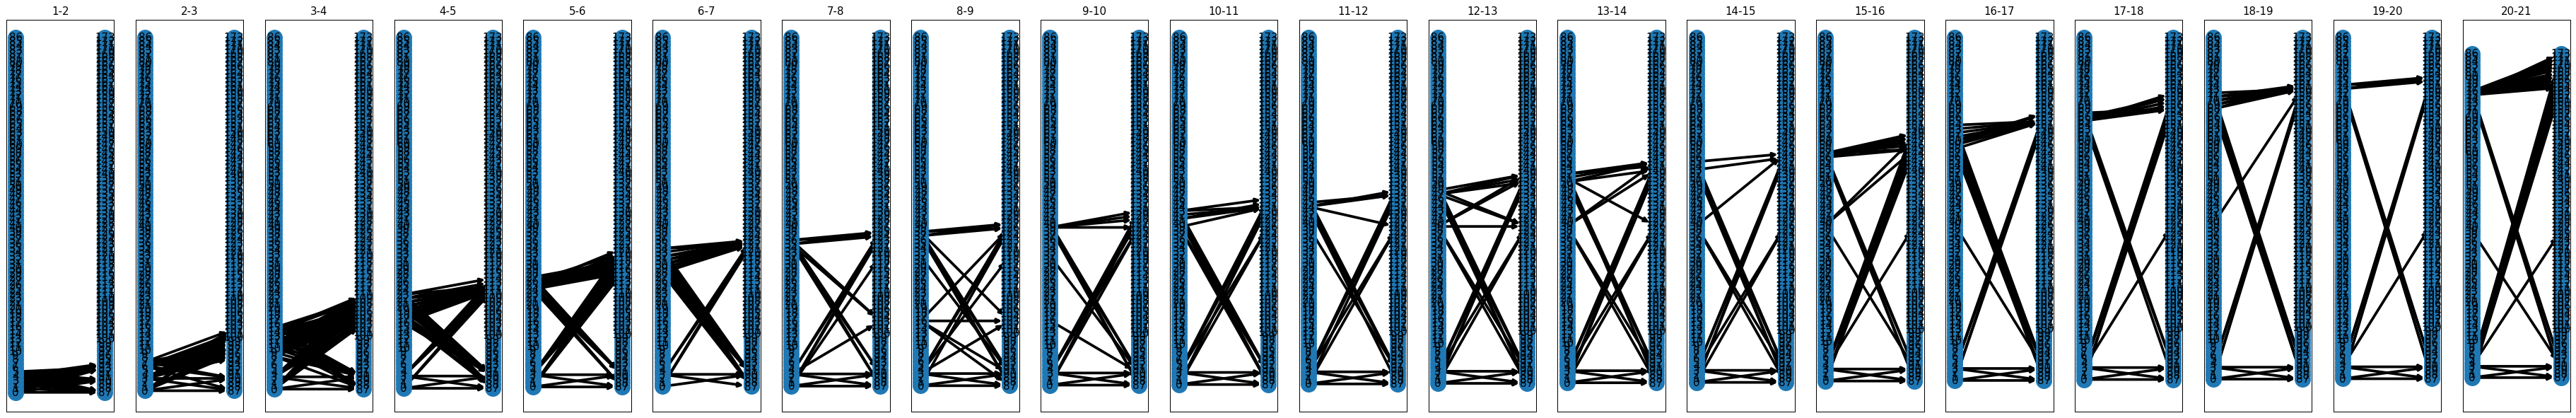

autoencoder2(
  (activation): custom_activation()
  (encoder): ModuleList(
    (0): gnn_net(
      (projector): ModuleList(
        (0): TAGConv(
          (lin): Linear(in_features=1024, out_features=30, bias=True)
        )
        (1): TAGConv(
          (lin): Linear(in_features=60, out_features=50, bias=True)
        )
        (2): TAGConv(
          (lin): Linear(in_features=100, out_features=75, bias=True)
        )
      )
    )
    (1): Linear(in_features=75, out_features=75, bias=False)
    (2): gnn_net(
      (projector): ModuleList(
        (0): TAGConv(
          (lin): Linear(in_features=1024, out_features=30, bias=True)
        )
        (1): TAGConv(
          (lin): Linear(in_features=60, out_features=50, bias=True)
        )
        (2): TAGConv(
          (lin): Linear(in_features=100, out_features=75, bias=True)
        )
      )
    )
  )
  (decod_node_layers): ModuleList(
    (0): Linear(in_features=150, out_features=75, bias=False)
    (1): Linear(in_features=75,

In [ ]:



if __name__ == '__main__':
    patterns, evolving_graphs, nbre_steps, data, net, feat = main(
        path_to_data=path_to_data,
        size=size,
        moving_step=moving_step,
        lag=lag,
        k=k,
        graph_lag=graph_lag,
        hidden_feats_encoder=hidden_feats_encoder,
        hidden_feats_node_decoder=hidden_feats_node_decoder,
        nbre_epoch=nbre_epoch,
        loss_encod=loss_encod,
        loss_node = loss_node,
        view_pattern_lifespan=view_pattern_lifespan,
        view_causal_graph=view_causal_graph,
        view_training=view_training
    )


In [ ]:
patterns.keys()

In [ ]:
step

In [ ]:
steps_index = {}
for k,dic in patterns.items():
    for j, step in enumerate(dic['steps']):
        if step not in steps_index:
            steps_index[step] = dic['time_intervals'][j]

In [ ]:
results = {}
results['MAE'] = []
results['MSE'] = []
for i, model in enumerate(patterns.keys()):
    for ser, j in enumerate(feat[(len(feat)//2) + i,:]):
        if j.item() == 1:
#             print(model, data.columns[ser],)
            past_values = data.loc[steps_index[step-1],[data.columns[ser]]].values.flatten()
#             print(step+1)
            current_values = data.loc[steps_index[step],[data.columns[ser]]].tail(moving_step).values.flatten()
            mod = patterns[model]['model']
            fore = forecasting(past_values, current_values, mod)
            results['MAE'].append(fore['MAE'])
            results['MSE'].append(fore['MSE'])
results = pd.DataFrame(results)
results.mean()

{'series': array([1.40041147, 1.43506763, 1.26952228, 1.25147377, 1.17708071,
       1.1260444 , 1.16085214, 0.95496309, 0.98029159, 0.85069144,
       0.92478133, 1.16775305, 1.19361245, 1.25549296, 1.09366339,
       1.14644374, 1.12240452, 1.18800081, 1.31851093, 1.20081676,
       1.32973443, 1.39821245, 1.74666919, 1.80961148, 1.61479412,
       1.58044136, 1.52553744, 1.38372815, 1.56368213]), 'predict': array([-0.84606697, -0.84574641, -0.84544429, -0.84476897, -0.84291182,
       -0.84147642, -0.83861486, -0.83811991, -0.83216855, -0.8202809 ,
       -0.81154371, -0.8048652 , -0.83092982, -0.84005261, -0.84181134,
       -0.83993156, -0.83665813, -0.83759642, -0.83878707, -0.84273484,
       -0.84293537, -0.84305883, -0.84488417, -0.84620304, -0.84640083,
       -0.84637158, -0.84623808, -0.84613724, -0.84572718]), 'MSE': 4.554473462884581, 'MAE': 2.120646735163936}


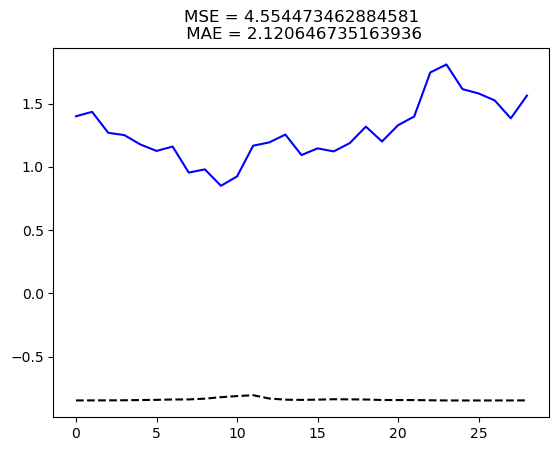

In [121]:
past_values = data.loc[steps_index[32],['MPWR']].values.flatten()
current_values = data.loc[steps_index[33],['MPWR']].tail(moving_step).values.flatten()
model = patterns['model'+str(index_model+1)]['model']
fore = forecasting(past_values, current_values, model)
print(fore)
plt.plot(fore['series'],'b-')
plt.plot(fore['predict'],'k--')
plt.title('MSE = '+str(fore['MSE'])+'\n MAE = '+str(fore['MAE']))
plt.show()

In [110]:
fore

{'series': array([1.40041147, 1.43506763, 1.26952228, 1.25147377, 1.17708071,
        1.1260444 , 1.16085214, 0.95496309, 0.98029159, 0.85069144,
        0.92478133, 1.16775305, 1.19361245, 1.25549296, 1.09366339,
        1.14644374, 1.12240452, 1.18800081, 1.31851093, 1.20081676,
        1.32973443, 1.39821245, 1.74666919, 1.80961148, 1.61479412,
        1.58044136, 1.52553744, 1.38372815, 1.56368213]),
 'predict': array([-0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 ,
        -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 ,
        -0.8562271 , -0.85622711, -0.8562271 , -0.8562271 , -0.8562271 ,
        -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 ,
        -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 ,
        -0.8562271 , -0.8562271 , -0.8562271 , -0.8562271 ]),
 'MSE': 4.625247081808707,
 'MAE': 2.137961213316341}

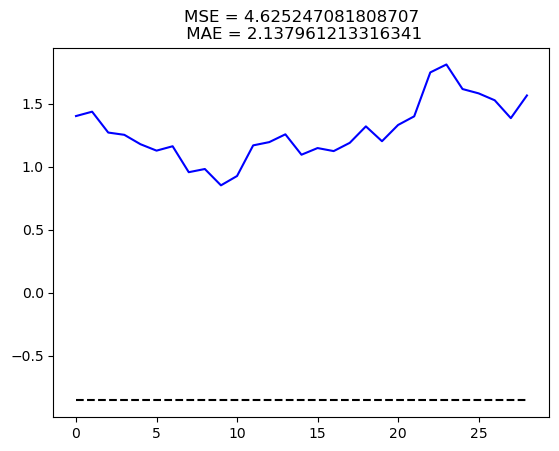

In [55]:
evolving_graphs['32-33']['dgl_graph'].ndata['features'].sum(axis=0)

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2.,
        2., 2., 2., 2.], dtype=torch.float64)

In [47]:
data.shape

(972, 76)

In [45]:
for i in range(len(feat)):
    print(i+1, feat[i,].sum())

1 tensor(26., grad_fn=<SumBackward0>)
2 tensor(25., grad_fn=<SumBackward0>)
3 tensor(25., grad_fn=<SumBackward0>)
4 tensor(25., grad_fn=<SumBackward0>)
5 tensor(26., grad_fn=<SumBackward0>)
6 tensor(26., grad_fn=<SumBackward0>)
7 tensor(26., grad_fn=<SumBackward0>)
8 tensor(32., grad_fn=<SumBackward0>)
9 tensor(26., grad_fn=<SumBackward0>)
10 tensor(32., grad_fn=<SumBackward0>)
11 tensor(26., grad_fn=<SumBackward0>)
12 tensor(25., grad_fn=<SumBackward0>)
13 tensor(26., grad_fn=<SumBackward0>)
14 tensor(26., grad_fn=<SumBackward0>)
15 tensor(26., grad_fn=<SumBackward0>)
16 tensor(26., grad_fn=<SumBackward0>)
17 tensor(24., grad_fn=<SumBackward0>)
18 tensor(25., grad_fn=<SumBackward0>)
19 tensor(33., grad_fn=<SumBackward0>)
20 tensor(27., grad_fn=<SumBackward0>)
21 tensor(25., grad_fn=<SumBackward0>)
22 tensor(26., grad_fn=<SumBackward0>)
23 tensor(30., grad_fn=<SumBackward0>)
24 tensor(26., grad_fn=<SumBackward0>)
25 tensor(36., grad_fn=<SumBackward0>)
26 tensor(25., grad_fn=<SumBackwar

In [24]:
test = pd.read_csv('/home/etienne/Téléchargements/practical1_2_data/daily_sentiments/Users_from_Australia_information_2021-08-31.csv', index_col=0)

In [26]:
test.sentiment.value_counts()

sentiment
-1    3753
 1    1139
 0    1111
Name: count, dtype: int64

In [27]:
test0, test2, test1 = test[test.sentiment == 0].sample(200), test[test.sentiment == -1].sample(600), test[test.sentiment == 1].sample(200)

In [28]:
testeur = pd.concat([test])

,user_id,valence_intensity,fear_intensity,anger_intensity,happiness_intensity,sadness_intensity,sentiment
918,1228096075,0.5090,0.2900,0.3320,0.2310,0.3800,0
5281,377277534,0.4745,0.5370,0.4415,0.3115,0.4300,0
4317,1362196277669158914,0.4890,0.4680,0.4770,0.2670,0.4510,0
5436,1324503741354012672,0.4825,0.4290,0.4805,0.3060,0.3795,0
3865,34204774,0.4420,0.4535,0.4430,0.2470,0.4375,0
...,...,...,...,...,...,...,...
4466,273375181,0.4870,0.4640,0.3620,0.2630,0.4380,0
1714,427978641,0.4940,0.3900,0.4610,0.3460,0.4140,0
3368,22705952,0.4840,0.5310,0.4340,0.3490,0.4690,0
4975,2339818350,0.5000,0.5180,0.3490,0.3270,0.4020,0
